# Deep Learning
## Formative assessment
### Week 10: Variational autoencoder

#### Instructions

In this notebook, you will write code to implement the variational autoencoder algorithm for an image dataset of celebrity faces. You will use the trained encoder and decoder networks to reconstruct and generate images. You will also see how the latent space encodes high-level information about the images.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

These cells require you to write your own code to complete them.

#### Let's get started!

We'll start by running some imports, and loading the dataset.

In [2]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D,  Conv2DTranspose, BatchNormalization
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# If you would like to make further imports from tensorflow, add them here






<img src="figures/celeba.png" title="CelebA" style="width: 650px;"/> 

#### The Large-scale CelebFaces Attributes (CelebA) Dataset

For this assignment you will use a subset of the [CelebFaces Attributes (CelebA) dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). The full dataset contains over 200K images CelebA contains thousands of colour images of the faces of celebrities, together with tagged attributes such as 'Smiling', 'Wearing glasses', or 'Wearing lipstick'. It also contains information about bounding boxes and facial part localisation. CelebA is a popular dataset that is commonly used for face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis. 

* Z. Liu, P. Luo, X. Wang, and X. Tang. "Deep Learning Face Attributes in the Wild", Proceedings of International Conference on Computer Vision (ICCV), 2015.

Your goal is to implement the variational autoencoder algorithm for a subset of the CelebA dataset. For practical reasons we will keep the dataset and the network size relatively small.

#### Load and preprocess the dataset

For this assignment, you will use a subset of the CelebA dataset. Note that the full dataset can be downloaded from [the CelebA dataset webpage](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)), but this is not necessary for this assignment. 

In addition, attribute labels for the subset have been saved in the CSV file `list_attr_celeba.csv`. We will use this in the last part of the assignment.

You should now write the following `load_dataset` function to create a `tf.data.Dataset` object from the files saved in the images folder.

* The function takes `split` as an argument, which will be equal to one of the strings `"train"`, `"val"` or  `"test"`, `batch_size`, an optional `shuffle_buffer` argument and `image_dir` argument
* The function should create a Dataset containing the filepaths saved in the corresponding `split` subfolder of the `image_dir` directory
* The function should include a nested function used to map the Dataset
  * This function will take the `filepath` as an argument
  * It should read the contents of the file saved at `filepath` - this will be a jpeg image
  * It should then decode the jpeg and scale the pixel values to lie in the range $[0, 1]$
  * It should then return two identical copies of the image Tensor in a 2-tuple
* The function should then apply the nested function using the `map` method
* If `shuffle_buffer` is not None, then it should be used to shuffle the Dataset
* It should then batch the Dataset using the `batch_size` argument
* Finally, the function should prefetch the Dataset using the argument `tf.data.AUTOTUNE`
* The function should then return the Dataset

_Hint: The Dataset can be created using_ `tf.data.Dataset.list_files`, _and using a wildcard character_ `'*.jpg'`_. Make sure that you set_ `shuffle=False` _when calling this method._

In [3]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def load_dataset(split, batch_size, shuffle_buffer=None, image_dir=str(Path('data', 'images'))):
    """
    This function should create a tf.data.Dataset object for one of the train/valid/test
    splits, according to the above specification.
    It should then return the Dataset.
    """
    dataset = tf.data.Dataset.list_files(str(Path(image_dir, split, '*.jpg')), shuffle=False)
    
    def load_image(filepath):
        raw_img = tf.io.read_file(filepath) 
        img_tensor = tf.image.decode_jpeg(raw_img, channels=3)
        img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
        return img_tensor, img_tensor
    
    dataset = dataset.map(load_image)
    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [4]:
# Use your function to obtain the train, valid and test Datasets

train_ds = load_dataset('train', 32, shuffle_buffer=500)
valid_ds = load_dataset('val', 32)
test_ds = load_dataset('test', 8)

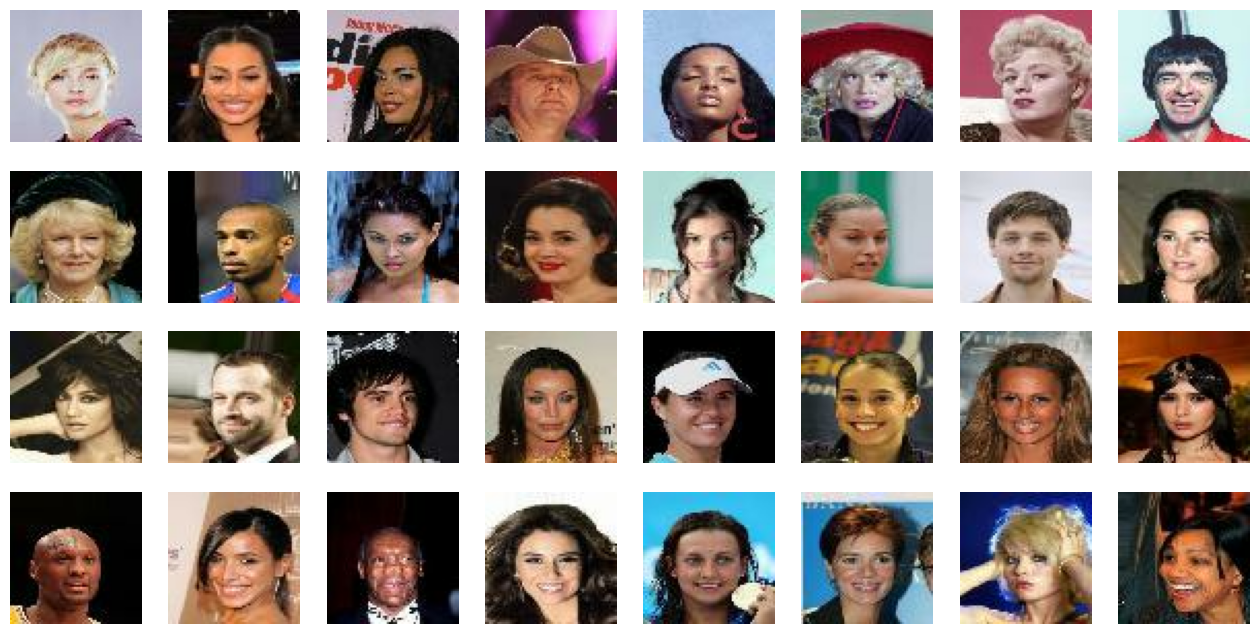

In [5]:
# Display a few examples

n_rows, n_cols = 4, 8
f, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))

for img_batch, _ in train_ds.take(1):
    for n, image in enumerate(img_batch):
        i = n // n_cols
        j = n % n_cols
        axs[i, j].imshow(image)
        axs[i, j].axis('off')

#### Define the prior distribution

We will define a prior distribution that is a mixture of Gaussians. You should now complete the following function to define the mixture of Gaussians distribution for the prior, for a given number of components and latent space dimension. Each Gaussian component will have a diagonal covariance matrix. This distribution will have fixed mixing coefficients, but trainable means and standard deviations. 

* The function takes `num_modes` (number of components) and `latent_dim` as arguments
* Use the `tfd.MixtureSameFamily` for the prior distribution. Take a look at [the documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MixtureSameFamily) for this distribution
  * The constructor takes a `mixture_distribution` and `components_distribution` as required arguments
  * The `mixture_distribution` should be fixed to a uniform `tfd.Categorical` distribution. This argument will therefore not contain any trainable variables
  * The `components_distribution` should be a `tfd.MultivariateNormalDiag` distribution with batch shape equal to `[num_modes]` and event shape equal to `[latent_dim]`. 
    * The `tfd.MultivariateNormalDiag` distribution should have trainable `loc` parameter (initialised with a random normal distribution)  and trainable `scale_diag` parameter (initialised to ones)
    * The `scale_diag` variable should be enforced to be positive using `tfp.util.TransformedVariable` and the `tfb.Softplus` bijection

The function should return the instance of the `tfd.MixtureSameFamily` distribution. 

In [6]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_prior(num_modes, latent_dim):
    """
    This function should create an instance of a MixtureSameFamily distribution 
    according to the above specification. 
    The function takes the num_modes and latent_dim as arguments, which should 
    be used to define the distribution.
    Your function should then return the distribution instance.
    """
    prior = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=[1/num_modes]*num_modes),
                components_distribution=tfd.MultivariateNormalDiag(
                    loc=tf.Variable(tf.random.normal((num_modes, latent_dim))),
                    scale_diag=tfp.util.TransformedVariable(
                            tf.ones(shape=(num_modes, latent_dim)), tfb.Softplus())))
    return prior

In [7]:
# Define the prior distribution with 2 components and 50 dimensions for the latent space

prior = get_prior(num_modes=2, latent_dim=50)

#### Define the encoder network

We will now define the encoder network as part of the VAE. First, we will define the `KLDivergenceAddLoss` layer to use in the encoder network to add the KL divergence part of the loss. This should be defined according to the following specification:

* The function takes the `prior_distribution` as an argument
* The function should create a `tfpl.KLDivergenceAddLoss` object to add the KL loss term
* The `tfpl.KLDivergenceAddLoss` should use a weight factor of 1.0 for the KL loss (standard ELBO objective)
* The KL loss cannot be computed exactly, so the `tfpl.KLDivergenceAddLoss` should compute a Monte Carlo approximation by drawing 3 samples from the posterior, and then averaging over the sample and batch axes

Your function should then return the `tfpl.KLDivergenceAddLoss` object.

In [8]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_kl_divergence_add_loss(prior_distribution):
    """
    This function should create an instance of the KLDivergenceAddLoss layer
    according to the above specification. 
    The function takes the prior_distribution, which should be used to define 
    the distribution.
    Your function should then return the KLDivergenceAddLoss instance.
    """
    kl_divergence_add_loss = tfpl.KLDivergenceAddLoss(prior_distribution, weight=1.0,
                                                      test_points_fn=lambda q: q.sample(3),
                                                      test_points_reduce_axis=(0, 1))
    return kl_divergence_add_loss

In [9]:
# Run your function to get the KLDivergenceAddLoss layer

kl_divergence_add_loss = get_kl_divergence_add_loss(prior)

You should now complete the following function to define the encoder network, according to the following specification:

* The function takes the `latent_dim` and `kl_divergence_add_loss` as arguments
* Use the `Sequential` class to define the model, which has the following layers:
  * A Conv2D layer with 32 filters, 3x3 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding. It should also set the `input_shape` to `(64, 64, 3)`
  * BatchNormalization layer
  * Conv2D layer with 64 filters, 3x3 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * BatchNormalization layer
  * Conv2D layer with 128 filters, 3x3 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * BatchNormalization layer
  * Conv2D layer with 256 filters, 3x3 kernel size, ReLU activation, stride of 2x2, and 'SAME' padding
  * BatchNormalization layer
  * Flatten layer
  * Dense layer with no activation function, and the right number of units to parameterise a `MultivariateNormalTriL` layer with event size equal to `latent_dim`
  * The penultimate layer should be a `MultivariateNormalTriL` layer with event size equal to `latent_dim`
  * The final layer should be the `kl_divergence_add_loss` passed in as the argument 
* In total, your model should have 12 layers. The function should then return the encoder model

In [10]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_encoder(latent_dim, kl_divergence_add_loss):
    """
    This function should build a CNN encoder model according to the above specification. 
    The function takes latent_dim and kl_divergence_add_loss as arguments, which should be
    used to define the model.
    Your function should return the encoder model.
    """
    encoder = Sequential([
        Conv2D(32, 3, activation='relu', strides=2,
               input_shape=(64, 64, 3), padding='same'), # (32, 32, 32)
        BatchNormalization(),
        Conv2D(64, 3, activation='relu', strides=2,
               padding='same'),  # (16, 16, 64)
        BatchNormalization(),
        Conv2D(128, 3, activation='relu', strides=2,
               padding='same'),  # (8, 8, 128)
        BatchNormalization(),
        Conv2D(256, 3, activation='relu', strides=2,
               padding='same'),  # (4, 4, 256)
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(event_size=latent_dim),
        kl_divergence_add_loss
    ], name='encoder')  
    return encoder

In [11]:
# Run your function to get the encoder

encoder = get_encoder(latent_dim=50, kl_divergence_add_loss=kl_divergence_add_loss)

In [12]:
# Print the encoder summary

encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 128)        512 

#### Define the decoder network

You should now define the decoder network for the VAE, using the `Sequential` API. This should be a neural network that returns an IndependentBernoulli distribution of `event_shape=(64, 64, 3)`.

* The function takes the `latent_dim` as an argument
* Use the `Sequential` class to define the model with the following layers:
  * A Dense layer with 4096 units and ReLU activation. It should also set the `input_shape` to `(latent_dim,)`
  * A Reshape layer, that reshapes its input to `(4, 4, 256)`
  * BatchNormalization layer
  * Conv2DTranspose layer with 128 filters, 3x3 kernel size, ReLU activation, stride of 2x2 and 'SAME' padding
  * BatchNormalization layer
  * Conv2DTranspose layer with 64 filters, 3x3 kernel size, ReLU activation, stride of 2x2 and 'SAME' padding
  * BatchNormalization layer
  * Conv2DTranspose layer with 32 filters, 3x3 kernel size, ReLU activation, stride of 2x2 and 'SAME' padding
  * BatchNormalization layer
  * Conv2DTranspose layer with 3 filters, 3x3 kernel size, no activation function, stride of 2x2 and 'SAME' padding
  * A Flatten layer
  * The final layer should be a `IndependentBernoulli` layer with event size equal to `(64, 64, 3)`
* The Conv2DTranspose layers will need to be configured such that the final Conv2DTranspose layer outputs the correct shape Tensor for the `IndependentBernoulli` layer
* In total, your model should have 12 layers. The function should then return the decoder model.

In [13]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_decoder(latent_dim):
    """
    This function should build a CNN decoder model according to the above specification. 
    The function takes latent_dim as an argument, which should be used to define the model.
    Your function should return the decoder model.
    """
    event_shape = (64, 64, 3)
    
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim,)),
        Reshape((4, 4, 256)),
        BatchNormalization(),
        Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same', output_padding=1),
        BatchNormalization(),
        Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same', output_padding=1),
        BatchNormalization(),
        Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same', output_padding=1),
        BatchNormalization(),
        Conv2DTranspose(3, 3, strides=2, padding='same', output_padding=1),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape)
    ], name='decoder')
    return decoder

In [14]:
# Run your function to get the decoder

decoder = get_decoder(latent_dim=50)

In [15]:
# Print the decoder summary

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              208896    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        295040    
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                           

#### Build and compile the end-to-end architecture

Now that the encoder and decoder networks are defined, you should now complete the following function to build the complete encoder-decoder architecture and compile the model, ready for training. 

* The function takes the `encoder` and `decoder` networks as arguments
* It should combine these networks together into a single `Model`
* The model should then be compiled with the loss, optimizer and metric
  * The loss should be the average reconstruction loss over the batch
  * The optimizer should be the Adam optimizer with learning rate equal to 5e-4
  * Add the mean absolute error metric to measure the model's performance
* The function should then return the `Model` object

In [16]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_compiled_model(encoder, decoder):
    """
    This function should compute and return the average expected reconstruction loss,
    as defined above.
    The function takes batch_of_images and decoding_dist as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
    
    def reconstruction_loss(batch_of_images, decoding_dist):
        return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    vae.compile(optimizer=optimizer, loss=reconstruction_loss, metrics=['mae'])
    return vae

In [17]:
# Run your function to define and compile the end-to-end architecture

vae = get_compiled_model(encoder, decoder)

#### Train the model

In [18]:
# Fit the model

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')
vae.fit(train_ds, validation_data=valid_ds, epochs=40, callbacks=[early_stopping])

Epoch 1/40
313/313 [==============================] - 13s 16ms/step - loss: 7802.2017 - mae: 0.4120 - val_loss: 7278.9624 - val_mae: 0.4216
Epoch 2/40
313/313 [==============================] - 4s 14ms/step - loss: 6939.4873 - mae: 0.3696 - val_loss: 6826.8564 - val_mae: 0.3639
Epoch 3/40
313/313 [==============================] - 4s 13ms/step - loss: 6806.4697 - mae: 0.3637 - val_loss: 6765.6372 - val_mae: 0.3556
Epoch 4/40
313/313 [==============================] - 4s 13ms/step - loss: 6732.2598 - mae: 0.3603 - val_loss: 6661.6523 - val_mae: 0.3555
Epoch 5/40
313/313 [==============================] - 4s 14ms/step - loss: 6662.2734 - mae: 0.3570 - val_loss: 6608.3794 - val_mae: 0.3533
Epoch 6/40
313/313 [==============================] - 5s 14ms/step - loss: 6604.1470 - mae: 0.3541 - val_loss: 6608.4355 - val_mae: 0.3468
Epoch 7/40
313/313 [==============================] - 5s 15ms/step - loss: 6565.3418 - mae: 0.3523 - val_loss: 6544.8071 - val_mae: 0.3503
Epoch 8/40
313/313 [======

In [19]:
# Evaluate the model on the test set

evaluation = vae.evaluate(test_ds, return_dict=True)
print("Test loss: {}, test MAE: {}".format(evaluation['loss'], evaluation['mae']))

125/125 [==============================] - 1s 6ms/step - loss: 6275.5049 - mae: 0.3300
Test loss: 6275.5048828125, test MAE: 0.32999321818351746


#### Compute reconstructions of test images

We will now take a look at some image reconstructions from the encoder-decoder architecture.

You should complete the following function, that uses `encoder` and `decoder` to reconstruct images from the test dataset. 

* This function takes the `encoder`, `decoder` and a Tensor `batch_of_images` as arguments
* It should then compute the reconstructions as follows:
  * Compute the means of the encoding distributions from passing the batch of images into the encoder
  * Pass these latent vectors through the decoder to get the output distribution
  * Compute the mean of the output distribution
* The function should then return the resulting Tensor, which will be of shape `(batch_size, 64, 64, 3)`

In [20]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def reconstruct(encoder, decoder, batch_of_images):
    """
    This function should compute reconstructions of the batch_of_images according
    to the above instructions.
    The function takes the encoder, decoder and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    mean_latent_vectors = encoder(batch_of_images).mean()
    mean_reconstructions = decoder(mean_latent_vectors).mean()
    return mean_reconstructions

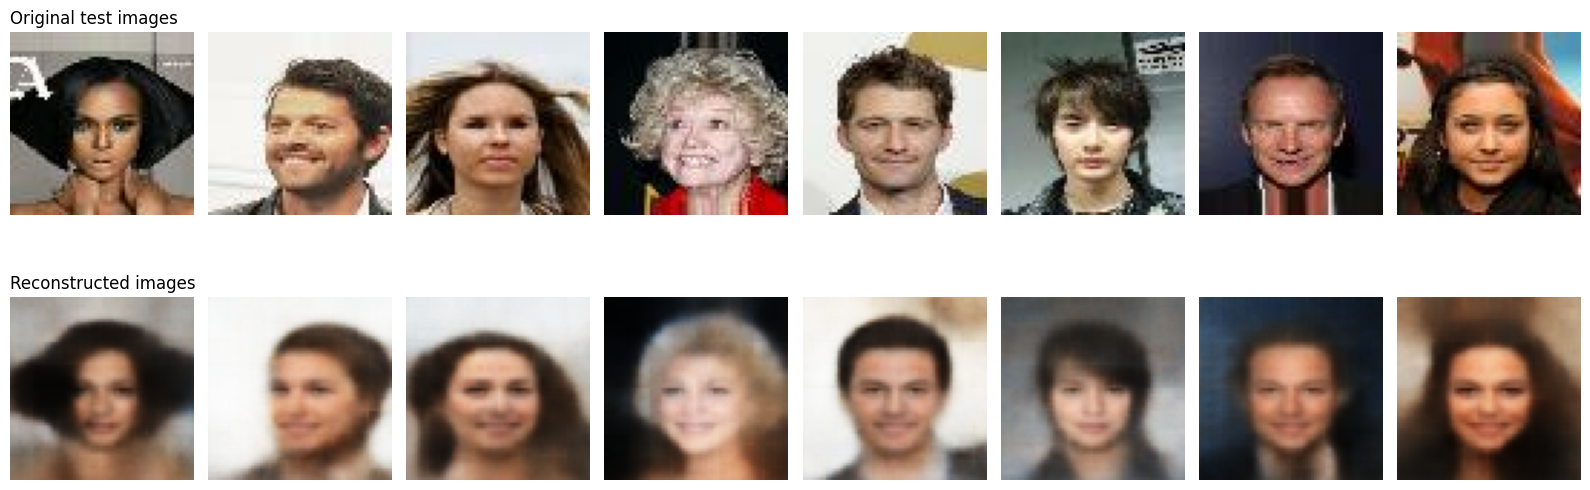

In [21]:
# Use your function to compute and visualise reconstructions

for test_batch, _ in test_ds.shuffle(100).take(1):
    reconstructions = reconstruct(encoder, decoder, test_batch)

test_batch_size = 8
f, axs = plt.subplots(2, test_batch_size, figsize=(16, 6))
axs[0, 0].set_title("Original test images", loc='left')
axs[1, 0].set_title("Reconstructed images", loc='left')
for j in range(test_batch_size):
    axs[0, j].imshow(test_batch.numpy()[j])
    axs[1, j].imshow(reconstructions.numpy()[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.tight_layout()

#### Sample from the generative model

You should complete the following `generate_images` function to generate new images. This function takes the prior distribution and decoder network as arguments, as well as the number of samples to generate. This function should be completed according to the following:

* Sample a batch of `n_samples` images from the prior distribution, to obtain a latent vector Tensor of shape `(n_samples, 50)`
* Pass this batch of latent vectors through the decoder, to obtain an Independent Bernoulli distribution with batch shape equal to `[n_samples]` and event shape equal to `[64, 64, 3]`.
* Compute the means of the output distribution
* The function should then return the means Tensor

In [22]:
 #### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def generate_images(prior, decoder, n_samples):
    """
    This function should compute generate new samples of images from the generative model,
    according to the above instructions.
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    sampled_latent_vectors = prior.sample(n_samples)
    sampled_images = decoder(sampled_latent_vectors).mean()
    return sampled_images

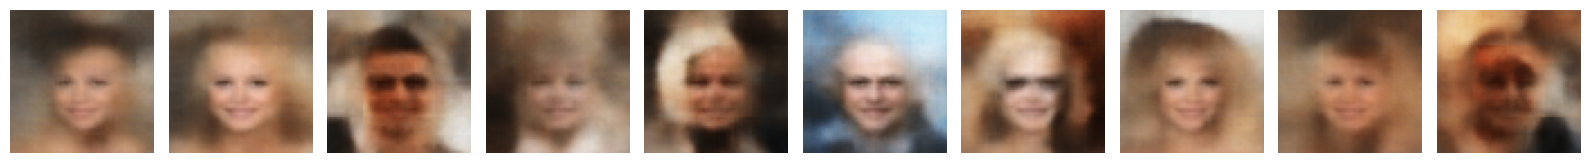

In [23]:
# Run your function to generate new images

n_samples = 10
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
plt.tight_layout()

#### Manipulate images in the latent space

In this final section, we will see how the latent space encodes high-level information about the images, even though it has not been trained with any information apart from the images themselves.

As mentioned earlier, each image in the CelebA dataset is labelled according to the attributes of the person pictured. The cell below will load these labels.

In [24]:
# Load the attribute labels

labels = pd.read_csv(Path('./data/list_attr_celeba_subset.csv'))
labels.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
1,000064.jpg,1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
2,000076.jpg,-1,-1,1,1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
3,000128.jpg,-1,1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,000129.jpg,1,-1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,-1,-1,1,1


As can be seen above, each image is labelled with a binary indicator (1 true, -1 false), according to whether it posseses the attribute. The list of attributes contained in the `labels` DataFrame is shown below.

In [25]:
# List the attributes contained in the DataFrame

labels.columns[1:]

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

We would like to perform some computations in the latent space, depending on the attribute values in the `labels` DataFrame. To do this, we will construct a new Dataset object, containing the images and attribute information.

You should now complete the following `get_labelled_dataset` function to construct this new Dataset.

* The function takes the arguments `split` (which again will be one of the strings `'train'`, `'val'` or `'test'`), an `attribute` string, the `labels` DataFrame and `image_dir` string
  * The `attribute` will be one of the column headers listed above
* As before, the function should create a Dataset containing the filepaths saved in the corresponding `split` subfolder of the `image_dir` directory
* The function should include a nested function used to map the Dataset similar to before
  * It should again read the contents of the file, decode the jpeg and scale the pixel values to lie in the range $[0, 1]$
  * It should then look up the `attribute` value for the image from the `labels` DataFrame
  * It should return a tuple containing the image Tensor, and scalar `tf.int32` label Tensor
* The function should then apply the nested function using the `map` method
* The function should then return the Dataset

_Hint: convert the filenames and attribute columns of the_ `labels` _DataFrame into separate Tensor objects for use in the map function. The_ `tf.strings.split` _and_ `tf.where` _functions will be useful to extract the label for a given image._

In [122]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_labelled_dataset(split, attribute, labels=labels, image_dir=str(Path('data', 'images'))):
    """
    This function should create a tf.data.Dataset object for one of the train/valid/test
    splits, according to the above specification.
    It should then return the Dataset.
    """
    filenames = tf.constant(labels['image_id'])
    labels = tf.constant(labels[attribute], dtype=tf.int32)
    dataset = tf.data.Dataset.list_files(str(Path(image_dir, split, '*.jpg')), shuffle=False)
    
    def load_image(filepath):
        filename = tf.strings.split(filepath, '/')[-1]
        i = tf.where(filenames == filename)
        raw_img = tf.io.read_file(filepath) 
        img_tensor = tf.image.decode_jpeg(raw_img, channels=3)
        img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
        label = labels[tf.squeeze(i)]
        return img_tensor, label
    
    dataset = dataset.map(load_image)
    return dataset

In [123]:
# Create the labelled Dataset from the train split

labelled_train_ds = get_labelled_dataset('train', 'Eyeglasses', labels=labels)

In [124]:
for ele in labelled_train_ds:
    print(ele)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Expected begin, end, and strides to be 1D equal size tensors, but got shapes [1,0], [1,0], and [1] instead.
	 [[{{node strided_slice_1}}]] [Op:IteratorGetNext]

We now would like to compute the 'attribute vector' for the chosen attribute. This will be the average latent vector corresponding to all images that have the attribute, minus the average latent vector corresponding to all images that do not have the attribute. The intuition is that this vector will correspond the high-level property of adding the attribute to an image.

You should now complete the following function to compute the attribute vector.

* The function takes `labelled_dataset` as an argument, as well as the `encoder` network
* The function should compute the encoding distribution mean (latent vector) for all images that have the attribute, and (separately) all the images that do not
* It should then compute the average of each of these two sets of latent vectors
* It should then compute `avg_latent_with_attribute - avg_latent_without_attribute`. This is the attribute vector
* The function should then return the attribute vector as a numpy array of shape `(latent_dim,)`

In [32]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_attribute_vector(labelled_dataset, encoder):
    """
    This function should compute and return the attribute vector according 
    to the above specification.
    """
    latent_dim = encoder.layers[-2].output[0].shape[-1]
    with_attribute_ds = labelled_dataset.filter(lambda i, l: tf.math.equal(l, 1)).batch(128)
    without_attribute_ds = labelled_dataset.filter(lambda i, l: tf.math.equal(l, -1)).batch(128)

    avg_latent_with_attribute = np.empty(shape=(0, latent_dim), dtype=np.float32)
    for images, _ in with_attribute_ds:
        latents = encoder(images).mean()
        avg_latent_with_attribute = np.concatenate((avg_latent_with_attribute, latents.numpy()), 
                                                   axis=0)
    avg_latent_with_attribute = np.mean(avg_latent_with_attribute, axis=0)    
    
    avg_latent_without_attribute = np.empty(shape=(0, latent_dim), dtype=np.float32)
    for images, _ in without_attribute_ds:
        latents = encoder(images).mean()
        avg_latent_without_attribute = np.concatenate((avg_latent_without_attribute, latents.numpy()), 
                                                      axis=0)
    avg_latent_without_attribute = np.mean(avg_latent_without_attribute, axis=0)    
    
    return avg_latent_with_attribute - avg_latent_without_attribute

In [33]:
# Get the attribute vector using your function

attribute_vector = get_attribute_vector(labelled_train_ds, encoder)

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Expected begin, end, and strides to be 1D equal size tensors, but got shapes [1,0], [1,0], and [1] instead.
	 [[{{node strided_slice_1}}]] [Op:IteratorGetNext]

We can view this attribute vector by decoding it:

In [ ]:
# Display the decoded attribute vector

decoded_a = decoder(attribute_vector[np.newaxis, ...]).mean()
plt.imshow(decoded_a.numpy().squeeze())
plt.axis('off');

We can now use the attribute vector to add the attribute to an image reconstruction, where that attribute wasn't present before. To do this, we can just add the attribute vector to the latent vector encoding of the image, and then decode the result. We can also adjust the strength of the attribute vector by scaling with a multiplicative parameter.

In [ ]:
# Add the attribute vector to a sample of images that don't have the attribute

k = 2.5  # Weighting of attribute vector
num_examples = 8
labelled_test_ds = get_labelled_dataset('test', 'Eyeglasses', labels=labels).shuffle(100)
images_without_attribute = []
reconstructions = []
modified_images = []
for image, label in labelled_test_ds:
    if label == 1:  # Only proceses images without the attribute
        continue
    else:
        images_without_attribute.append(image.numpy())
        encoding = encoder(image[tf.newaxis, ...]).mean()
        decoded_image = decoder(encoding).mean()
        reconstructions.append(np.squeeze(decoded_image.numpy()))
        modified_encoding = encoding + (k * attribute_vector)
        modified_reconstruction = decoder(modified_encoding).mean()
        modified_images.append(np.squeeze(modified_reconstruction.numpy()))
    if len(modified_images) >= num_examples:
        break

In [ ]:
# Display the original images, their reconstructions, and modified reconstructions

num_examples = 8
f, axs = plt.subplots(3, num_examples, figsize=(16, 6))
axs[0, 0].set_title("Original images", loc='left')
axs[1, 0].set_title("Reconstructed images", loc='left')
axs[2, 0].set_title("Images with added attribute", loc='left')
for j in range(num_examples):
    axs[0, j].imshow(images_without_attribute[j])
    axs[1, j].imshow(reconstructions[j])
    axs[2, j].imshow(modified_images[j])
    for ax in axs[:, j]: ax.axis('off')
    
plt.tight_layout();

You could also try removing the attribute from images that possess the attribute, or experiment with a different attribute.

Congratulations on completing this week's assignment! In this assignment you have developed the variational autoencoder algorithm for the CelebA dataset, using tools from the TensorFlow Probability library, and used the trained networks to generate samples, compute reconstructions, and modify dataset images with high-level semantic information extracted from the latent space.